### Lineapy to automate data science work


<div>
<img src="https://user-images.githubusercontent.com/724072/165418570-7338c65b-0fd1-489c-b76a-f03f074f42ca.png" width="600"/>

</div>


In [1]:
%load_ext lineapy

In [2]:
import os
import lineapy


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

dataset.isna().sum()


dataset.loc['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
#one hot encoding
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

train_dataset.describe().transpose()

#normalization
train_dataset.describe().transpose()[['mean', 'std']]


first = np.array(train_dataset[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
  #drop na


First example: [[  28.     4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]



In [5]:
test_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
1.0             0
2.0             0
3.0             0
dtype: int64

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

Metal device set to: Apple M1


2022-06-18 01:24:11.418252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-18 01:24:11.418424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-18 01:24:11.449571: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-18 01:24:11.501898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-18 01:24:11.518118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
# Store the variable as an artifact
train_data_artifact = lineapy.save(train_features, "train_data")

# Check object type
print(type(train_data_artifact))



<class 'lineapy.api.api_classes.LineaArtifact'>


In [8]:
train_data_artifact.get_value().head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,1.0,2.0,3.0
146,4.0,90.0,75.0,2125.0,14.5,74.0,1,0,0
282,4.0,140.0,88.0,2890.0,17.3,79.0,1,0,0
69,8.0,350.0,160.0,4456.0,13.5,72.0,1,0,0
378,4.0,105.0,63.0,2125.0,14.7,82.0,1,0,0
331,4.0,97.0,67.0,2145.0,18.0,80.0,0,0,1


In [9]:
print(train_data_artifact.get_code())

import pandas as pd

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)
dataset = raw_dataset.copy()
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="", prefix_sep="")
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_features = train_dataset.copy()
train_labels = train_features.pop("MPG")



In [10]:
# copy the above codes here to verify.

In [11]:
# Store the variable as an artifact
lineapy.save(train_labels, "train_labels")

# Check object type
print(type(train_labels))

# Store the variable as an artifact
test_data_artifact = lineapy.save(test_features, "test_data")

# Check object type
print(type(test_data_artifact))

# Store the variable as an artifact
train_label_art = lineapy.save(test_labels, "test_labels")

# Check object type
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'lineapy.api.api_classes.LineaArtifact'>
<class 'pandas.core.series.Series'>


2022-06-18 01:24:14.414712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-18 01:24:14.561136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


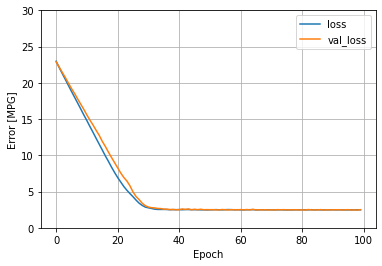

In [12]:
#Linear regression Model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])



#linear_model.predict(train_features[:10])

#linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 30])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


2022-06-18 01:24:18.241410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-18 01:24:18.417997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


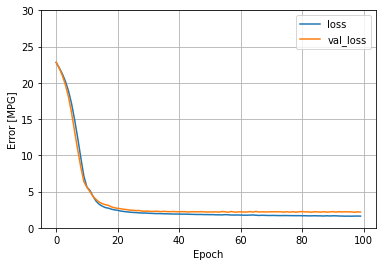

In [13]:
#DNN Model
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 30])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

    
plot_loss(history)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)



In [14]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.528774
dnn_model,1.728310


In [15]:
model_artifact = lineapy.save(dnn_model, 'dnn_model')
test_results_artifact = lineapy.save(test_results, 'test_results')

Assets written to: ram://5e58ca90-18a2-4258-89e0-22ef7ff1f601/assets

In [16]:
print(model_artifact.get_code())

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)
dataset = raw_dataset.copy()
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="", prefix_sep="")
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_features = train_dataset.copy()
train_labels = train_features.pop("MPG")
normalizer = tf.keras.layers.Normalization(axis=-1)


def build_and_compile_model(norm):
    model = keras.Sequential(
        [
            norm,
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            laye

In [17]:
# List all saved artifacts
lineapy.artifact_store()

train_data:0 created on 2022-06-16 19:39:55.833463
train_data:1 created on 2022-06-17 02:31:34.222560
train_labels:0 created on 2022-06-17 02:31:47.336271
test_data:0 created on 2022-06-17 02:31:47.741501
test_labels:0 created on 2022-06-17 02:31:48.150291
train_data:2 created on 2022-06-17 02:37:44.322165
train_labels:1 created on 2022-06-17 02:37:49.389819
test_data:1 created on 2022-06-17 02:37:49.799428
test_labels:1 created on 2022-06-17 02:37:50.209388
train_data:3 created on 2022-06-17 02:56:02.199295
train_labels:2 created on 2022-06-17 02:56:14.624117
test_data:2 created on 2022-06-17 02:56:15.050927
test_labels:2 created on 2022-06-17 02:56:15.447512
train_data:4 created on 2022-06-17 02:59:00.727015
train_labels:3 created on 2022-06-17 02:59:05.123476
test_data:3 created on 2022-06-17 02:59:05.524397
test_labels:3 created on 2022-06-17 02:59:05.913697
train_data:5 created on 2022-06-17 03:00:11.696949
train_labels:4 created on 2022-06-17 03:00:14.147130
test_data:4 created o

By default, the get() method retrieves the latest version of the given artifact. To retrieve a particular version of the artifact, we can specify the value of the optional argument version

In [18]:
lineapy.get('train_data').version

12

In [19]:
train_mod_art = lineapy.get('train_data', version=7)

In [20]:
train_mod_art.get_value().head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,1.0,2.0,3.0
114,4.0,98.0,90.0,2265.0,15.5,73.0,0,1,0
283,6.0,232.0,90.0,3265.0,18.2,79.0,1,0,0
69,8.0,350.0,160.0,4456.0,13.5,72.0,1,0,0
157,8.0,350.0,145.0,4440.0,14.0,75.0,1,0,0
332,4.0,89.0,62.0,1845.0,15.3,80.0,0,1,0


Given the recurring updates in the source data, we may want to build and schedule a pipeline to automatically rerun the code of both artifacts on a regular basis.

In [21]:
# Build an Airflow pipeline with both length and width artifacts
lineapy.to_pipeline(
    artifacts=[train_data_artifact.name, train_label_art.name, train_mod_art.name, test_data_artifact.name, test_results_artifact.name],
    pipeline_name="demo_pipeline",
    framework="AIRFLOW",
    dependencies={
      train_mod_art.name: { train_data_artifact.name, train_label_art.name}, test_results_artifact.name:{train_mod_art.name, test_data_artifact.name}
   },
    output_dir="output/00_api_basics/demo_pipeline/",
)

Pipeline source generated in the directory: output/00_api_basics/demo_pipeline

Generated python module demo_pipeline.py

Generated Dockerfile demo_pipeline_Dockerfile

Generated requirements file demo_pipeline_requirements.txt

Added Airflow DAG named demo_pipeline_dag. Start a run from the Airflow UI or CLI.

PosixPath('output/00_api_basics/demo_pipeline')

In [22]:
!ls output/00_api_basics/demo_pipeline

demo_pipeline.py               demo_pipeline_dag.py
demo_pipeline_Dockerfile       demo_pipeline_requirements.txt


In [23]:
!cat output/00_api_basics/demo_pipeline/demo_pipeline_dag.py

import os

import demo_pipeline
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago

default_dag_args = {"owner": "airflow", "retries": 2, "start_date": days_ago(1)}

dag = DAG(
    dag_id="demo_pipeline_dag",
    schedule_interval="*/15 * * * *",
    max_active_runs=1,
    catchup=False,
    default_args=default_dag_args,
)


train_data = PythonOperator(
    dag=dag,
    task_id="train_data_task",
    python_callable=demo_pipeline.train_data,
)

test_labels = PythonOperator(
    dag=dag,
    task_id="test_labels_task",
    python_callable=demo_pipeline.test_labels,
)

train_data = PythonOperator(
    dag=dag,
    task_id="train_data_task",
    python_callable=demo_pipeline.train_data,
)

test_data = PythonOperator(
    dag=dag,
    task_id="test_data_task",
    python_callable=demo_pipeline.test_data,
)

test_results = PythonOperator(
    dag=dag,
    task_id="test_results_task",
    python_callable=demo_pipelin

In [24]:
!cat output/00_api_basics/demo_pipeline/demo_pipeline_requirements.txt

lineapy
matplotlib==3.5.2
numpy==1.22.4
pandas==1.4.2
seaborn==0.11.2
tensorflow==2.9.2
tensorflow.keras==2.9.0
